# DATA ANALYSIS WITH PYSPARK

**This notebook has the purpose of practice and understand the usage of pyspark to perform data analysis**

## IMPORTS

In [102]:
import folium
import os, sys, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from datetime import datetime as dt
from pandas import DataFrame

## HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 50
  
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(round(float(p.get_height()),2)), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

def city_temp_lineplot(df, city:str):
    
    if isinstance(city, str):
        df_city = df1[df1['city'] == f'{city.title()}']

        ax = sns.lineplot(df_city['day'], df_city['avg(temp_C)'], markers=True, dashes=False)
        ax.set_title(f"Temperature Variation {city.title()}", fontsize=14)
        ax.set_ylabel("Temp (C)")
        ax.axhline(0, color="k", linestyle="--")
    else: raise ValueError("City name must to a string.")
    
    return ax

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## SET SPARK SESSION

**SparkSession**

    - A SparkSession is an entry point to underlying PySpark functionality in order to programmatically create PySpark RDD, DataFrame.

In [83]:
pyspark = SparkSession.builder.appName("temp_analysis").master('local[*]').getOrCreate()

## LOAD DATAFRAME FROM PARQUET FILE

**RDD**

    - RDD stands for Resilient Distributed Dataset, these are the elements that run and operate on multiple nodes to do parallel processing on a cluster. RDDs are immutable elements.

In [84]:
df = pyspark.read.parquet('../../data/data_lake/cleansed/clean_openweather_20220122.parquet')

## FIRST LOOK INTO THE DATA

In [85]:
df.show()

+-------------------+-------+-------+-------+-----------+------+--------+--------+----------+--------+--------------------+---------+------+------+----+
|         created_at|city_id|    lat|    lon|    country|  temp|max_temp|min_temp|feels_like|humidity|                  id|     city|temp_F|temp_C|hour|
+-------------------+-------+-------+-------+-----------+------+--------+--------+----------+--------+--------------------+---------+------+------+----+
|2021-12-19 11:49:26|2950159|52.5244|13.4105|    Germany|279.39|  280.79|  278.76|    275.21|      91|"61bf0e36c0963c89...|   Berlin| 43.23|  6.24|  11|
|2021-12-19 11:49:31|2988507|48.8534| 2.3488|     France|277.89|  278.62|  277.19|    276.44|      97|"61bf0e3bc0963c89...|    Paris| 40.53|  4.74|  11|
|2021-12-19 11:49:36|3128760|41.3888|  2.159|      Spain|284.19|  286.78|  281.78|    283.36|      77|"61bf0e40c0963c89...|Barcelona| 51.87| 11.04|  11|
|2021-12-19 11:49:41|2759794| 52.374| 4.8897|Netherlands| 280.2|   281.4|  279.19|

In [86]:
# SHAPE
print(f"Number of rows: {df.count()}\nNumber of columns: {len(df.columns)}")

Number of rows: 1031
Number of columns: 15


## DATA ANALYSIS WITH PYSPARK

#### DAILY TEMPERATURE ANALYSIS.

In [89]:
# AVERAGE TEMPS GROUPED BY CITY AND DAY
df_grouped_city_day = df.groupBy("city").mean("humidity", "temp_F", "temp_C", "feels_like").orderBy("city")
df_grouped_city_day.show()

+---------+-----------------+------------------+------------------+------------------+
|     city|    avg(humidity)|       avg(temp_F)|       avg(temp_C)|   avg(feels_like)|
+---------+-----------------+------------------+------------------+------------------+
|Amsterdam|88.68027210884354|36.739863945578236|2.6329251700680274|274.52816326530615|
|Barcelona|78.27027027027027| 52.16432432432432|11.202432432432433| 283.7125675675673|
|   Berlin|88.47651006711409|33.535436241610725|0.8529530201342282| 270.7775838926176|
|   Krakow|79.24489795918367|29.807346938775506|-1.218299319727891|269.13741496598647|
|   London|87.13793103448276|42.104827586206895| 5.613586206896554|277.22586206896545|
|    Paris|87.46979865771812| 38.85530201342284| 3.808523489932887| 276.1936912751678|
|   Vienna|75.58219178082192| 35.03863013698631|1.6880136986301373| 273.7164383561643|
+---------+-----------------+------------------+------------------+------------------+



In [90]:
# CREATE A TEMPVIEW
df_grouped_city_day.createOrReplaceTempView("mean_temp_by_city_and_day")

In [91]:
# USING SQL TO ANALYSE THE DATA

df1 = pyspark.sql("SELECT * FROM mean_temp_by_city_and_day")
df1.show()

+---------+-----------------+------------------+------------------+------------------+
|     city|    avg(humidity)|       avg(temp_F)|       avg(temp_C)|   avg(feels_like)|
+---------+-----------------+------------------+------------------+------------------+
|Amsterdam|88.68027210884354|36.739863945578236|2.6329251700680274|274.52816326530615|
|Barcelona|78.27027027027027| 52.16432432432432|11.202432432432433| 283.7125675675673|
|   Berlin|88.47651006711409|33.535436241610725|0.8529530201342282| 270.7775838926176|
|   Krakow|79.24489795918367|29.807346938775506|-1.218299319727891|269.13741496598647|
|   London|87.13793103448276|42.104827586206895| 5.613586206896554|277.22586206896545|
|    Paris|87.46979865771812| 38.85530201342284| 3.808523489932887| 276.1936912751678|
|   Vienna|75.58219178082192| 35.03863013698631|1.6880136986301373| 273.7164383561643|
+---------+-----------------+------------------+------------------+------------------+



In [92]:
# DF1 TO PANDAS - PLOT
df1 = df.toPandas()
df1.head()

created_at  city_id      lat      lon      country    temp  max_temp  min_temp  feels_like  humidity                          id       city  temp_F  temp_C  hour
0 2021-12-19 11:49:26  2950159  52.5244  13.4105      Germany  279.39    280.79    278.76      275.21        91  "61bf0e36c0963c8999e503e5"     Berlin   43.23    6.24    11
1 2021-12-19 11:49:31  2988507  48.8534   2.3488       France  277.89    278.62    277.19      276.44        97  "61bf0e3bc0963c8999e503e6"      Paris   40.53    4.74    11
2 2021-12-19 11:49:36  3128760  41.3888   2.1590        Spain  284.19    286.78    281.78      283.36        77  "61bf0e40c0963c8999e503e7"  Barcelona   51.87   11.04    11
3 2021-12-19 11:49:41  2759794  52.3740   4.8897  Netherlands  280.20    281.40    279.19      278.34        94  "61bf0e45c0963c8999e503e8"  Amsterdam   44.69    7.05    11
4 2021-12-19 11:49:46  3094802  50.0833  19.9167       Poland  278.40    279.01    276.56      278.40        89  "61bf0e4ac0963c8999e503e9"     Krakow   41.45    5.25    11

In [93]:
NOW = dt.now()
NOW.date()

datetime.date(2022, 1, 24)

In [95]:
df1.head(2)

created_at  city_id      lat      lon  country    temp  max_temp  min_temp  feels_like  humidity                          id    city  temp_F  temp_C  hour
0 2021-12-19 11:49:26  2950159  52.5244  13.4105  Germany  279.39    280.79    278.76      275.21        91  "61bf0e36c0963c8999e503e5"  Berlin   43.23    6.24    11
1 2021-12-19 11:49:31  2988507  48.8534   2.3488   France  277.89    278.62    277.19      276.44        97  "61bf0e3bc0963c8999e503e6"   Paris   40.53    4.74    11

In [103]:
def group_data(df: DataFrame) -> DataFrame:    
    df["date"] = df["created_at"].apply(lambda date: date.strftime("%Y-%m-%d"))
    df["date"] = pd.to_datetime(df1["date"])
    df = df.groupby(["hour", "date", "city"])[["temp_F", "temp_C", "humidity"]].mean().reset_index()
    return df

In [104]:
df_test = group_data(df1)
df_test.head()

hour       date       city  temp_F  temp_C  humidity
0     0 2021-12-21  Amsterdam   33.03    0.57      92.0
1     0 2021-12-21  Barcelona   46.42    8.01      71.0
2     0 2021-12-21     Krakow   27.45   -2.53      62.0
3     0 2021-12-21     London   41.27    5.15      81.0
4     0 2021-12-21     Vienna   32.13    0.07      75.0

In [111]:
max_date = max(df_test["date"])
max_hour = max(df_test["hour"])
df_date = df_test[df_test["date"] == max_date]
df_hour = df_date[df_date["hour"] == max_hour]
df_hour

Empty DataFrame
Columns: [hour, date, city, temp_F, temp_C, humidity]
Index: []

In [114]:
df_date

hour       date       city  temp_F  temp_C  humidity
39     2 2021-12-25  Amsterdam  36.390   2.440      92.0
40     2 2021-12-25     Krakow  33.760   0.980      91.0
41     2 2021-12-25     Vienna  46.560   8.090      86.0
50     3 2021-12-25  Amsterdam  35.420   1.900      91.0
51     3 2021-12-25  Barcelona  53.375  11.875      84.0
52     3 2021-12-25     Berlin  21.550  -5.805      86.0
53     3 2021-12-25     Krakow  33.510   0.840      89.0
54     3 2021-12-25     London  46.885   8.270      96.0
55     3 2021-12-25      Paris  47.775   8.765      97.0
56     3 2021-12-25     Vienna  46.740   8.190      85.0
63     4 2021-12-25  Amsterdam  34.610   1.450      91.0
64     4 2021-12-25  Barcelona  52.790  11.550      85.0
65     4 2021-12-25     Berlin  20.525  -6.375      87.0
66     4 2021-12-25     Krakow  33.055   0.585      89.0
67     4 2021-12-25     London  46.760   8.200      97.0
68     4 2021-12-25      Paris  47.645   8.690      97.0
69     4 2021-12-25     Vienna  46.310   7.950      86.5
81     5 2021-12-25  Amsterdam  33.650   0.915      90.0
82     5 2021-12-25  Barcelona  52.610  11.450      85.0
83     5 2021-12-25     Berlin  20.530  -6.370      87.0
84     5 2021-12-25     Krakow  30.180  -1.010      85.5
85     5 2021-12-25     London  46.670   8.150      97.0
86     5 2021-12-25      Paris  47.930   8.850      97.0
87     5 2021-12-25     Vienna  45.880   7.710      87.5

In [112]:
max_hour

23

In [113]:
max_date

Timestamp('2021-12-25 00:00:00')

In [76]:

def groupby_date_city(df: DataFrame) -> DataFrame:
    df["date"] = df["created_at"].apply(lambda date: date.strftime("%Y-%m-%d"))
    df["date"] = pd.to_datetime(df1["date"])
    df = df.groupby(["date", "city"])[["temp_F", "temp_C", "humidity"]].mean().reset_index()

    return df


date       city     temp_F  temp_C  humidity
0 2021-12-19  Amsterdam  44.690000    7.05      94.0
1 2021-12-19  Barcelona  51.870000   11.04      77.0
2 2021-12-19     Berlin  43.266667    6.26      91.0
3 2021-12-19     Krakow  41.450000    5.25      89.0
4 2021-12-19     London  40.080000    4.49      98.0

Text(0, 0.5, 'Temperature - C')

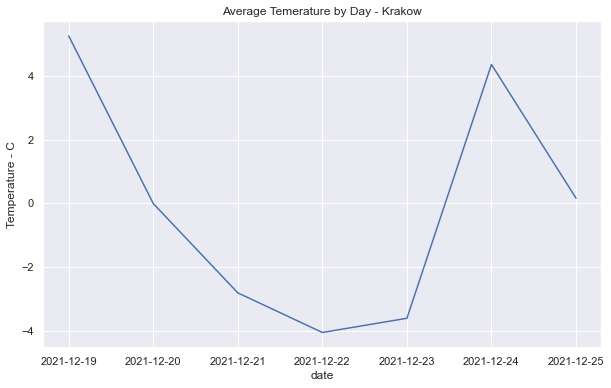

In [81]:
def line_plot_by_day(df: DataFrame, city: str) -> None:
    df3 = df2[df2["city"] == city]
    df3.head()
    sns.lineplot(x=df3["date"], y=df3["temp_C"], markers='o')
    plt.title(f"Average Temerature by Day - {city}")
    plt.ylabel("Temperature - C")

In [72]:
hour = dt.now().hour
df2 = df1.groupby(["city", "hour"])[["temp_F", "temp_C", "humidity"]].mean().reset_index()
df2["temp_F"] = round(df2["temp_F"],2)
df2["temp_C"] = round(df2["temp_C"],2)
df2["humidity"] = round(df2["humidity"],2)
df3 = df2[df2["hour"] == hour].drop(columns="hour")
df3

city  temp_F  temp_C  humidity
7    Amsterdam   34.68    1.49     92.43
31   Barcelona   49.87    9.93     81.62
55      Berlin   33.25    0.70     88.86
79      Krakow   26.50   -3.06     83.00
102     London   39.38    4.10     90.57
126      Paris   36.18    2.32     91.33
150     Vienna   28.93   -1.70     80.71

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Temperature Variation Berlin'}, xlabel='day', ylabel='Temp (C)'>

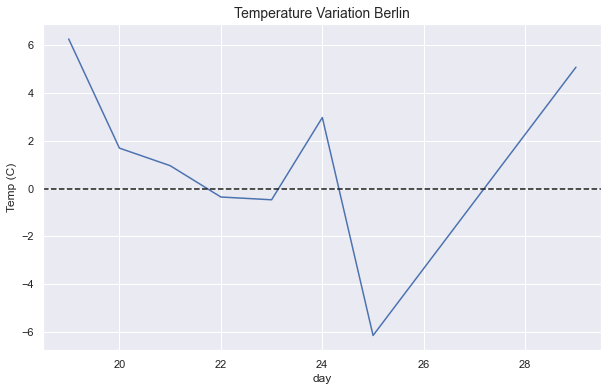

In [14]:
# EXEMPLE PLOT
city_temp_lineplot(df1, 'Berlin')

#### HOURLY TEMPERATURE ANALYSIS.

In [15]:
# AVERAGE TEMPS GROUPED BY CITY AND HOUR
df_grouped_city_hour = df.groupBy("city", "day", "hour").mean("lat", "lon", "humidity", "min_temp_F", "temp_F", "max_temp_F", "feels_like_F", "min_temp_C", "temp_C", "max_temp_C", "feels_like_C").orderBy("city", "day", "hour")
df_grouped_city_hour.show()

+---------+---+----+--------+--------+-------------+------------------+------------------+---------------+------------------+---------------+------------------+---------------+------------------+
|     city|day|hour|avg(lat)|avg(lon)|avg(humidity)|   avg(min_temp_F)|       avg(temp_F)|avg(max_temp_F)| avg(feels_like_F)|avg(min_temp_C)|       avg(temp_C)|avg(max_temp_C)| avg(feels_like_C)|
+---------+---+----+--------+--------+-------------+------------------+------------------+---------------+------------------+---------------+------------------+---------------+------------------+
|Amsterdam| 19|  11|  52.374|  4.8897|         94.0|             42.87|             44.69|          46.85|             41.34|           6.04|              7.05|           8.25|              5.19|
|Amsterdam| 20|   8|  52.374|  4.8897|         80.0|            39.055|41.849999999999994|          44.89|             40.67|           3.92| 5.470000000000001|           7.16|4.8149999999999995|
|Amsterdam| 20|   9|

In [16]:
# CREATE A TEMPVIEW
df_grouped_city_hour.createOrReplaceTempView("mean_temp_by_city_day_and_hour")

In [17]:
df2 = pyspark.sql("SELECT * FROM mean_temp_by_city_day_and_hour")
df2.show()

+---------+---+----+--------+--------+-------------+------------------+------------------+---------------+------------------+---------------+------------------+---------------+------------------+
|     city|day|hour|avg(lat)|avg(lon)|avg(humidity)|   avg(min_temp_F)|       avg(temp_F)|avg(max_temp_F)| avg(feels_like_F)|avg(min_temp_C)|       avg(temp_C)|avg(max_temp_C)| avg(feels_like_C)|
+---------+---+----+--------+--------+-------------+------------------+------------------+---------------+------------------+---------------+------------------+---------------+------------------+
|Amsterdam| 19|  11|  52.374|  4.8897|         94.0|             42.87|             44.69|          46.85|             41.34|           6.04|              7.05|           8.25|              5.19|
|Amsterdam| 20|   8|  52.374|  4.8897|         80.0|            39.055|41.849999999999994|          44.89|             40.67|           3.92| 5.470000000000001|           7.16|4.8149999999999995|
|Amsterdam| 20|   9|

In [18]:
# DF2 TO PANDAS - PLOT
df2 = df2.toPandas()
df2.head()

city  day  hour  avg(lat)  avg(lon)  avg(humidity)  avg(min_temp_F)  avg(temp_F)  avg(max_temp_F)  avg(feels_like_F)  avg(min_temp_C)  avg(temp_C)  avg(max_temp_C)  avg(feels_like_C)
0  Amsterdam   19    11    52.374    4.8897           94.0           42.870        44.69           46.850             41.340            6.040        7.050             8.25              5.190
1  Amsterdam   20     8    52.374    4.8897           80.0           39.055        41.85           44.890             40.670            3.920        5.470             7.16              4.815
2  Amsterdam   20     9    52.374    4.8897           84.0           38.975        41.17           44.890             41.170            3.875        5.095             7.16              5.095
3  Amsterdam   20    10    52.374    4.8897           85.0           39.850        41.52           44.890             41.520            4.360        5.290             7.16              5.290
4  Amsterdam   20    11    52.374    4.8897           83.0           40.370        42.56           45.375             41.895            4.650        5.865             7.43              5.495

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


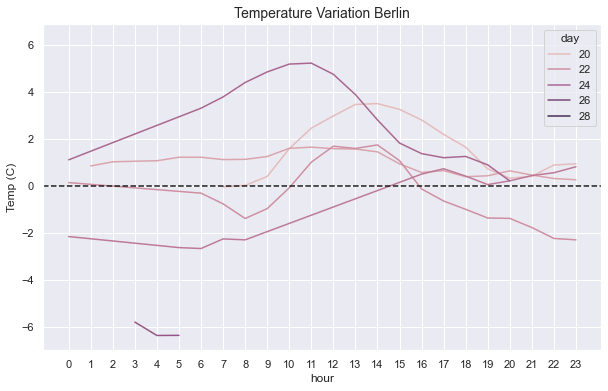

In [25]:
df_city = df2[df2['city'] == f'Berlin']

ax = sns.lineplot(df_city['hour'], df_city['avg(temp_C)'], hue=df2["day"], markers=True, dashes=False)
ax.set_title(f"Temperature Variation Berlin", fontsize=14)
ax.set_ylabel("Temp (C)")
ax.axhline(0, color="k", linestyle="--")
ax.set_xticks(range(0, 24));

#### MAP VISUALIZATION

In [44]:
# CENTER EUROPE LAT/LONG
lat = 47.0000
long = 9.0000

# INSTANCE MAP
map_ = folium.Map(location = [lat, long], zoom_start = 5.5)

# PLOT CITIES
for lat, lng, city, temp, hum in zip(df2['avg(lat)'],
                                     df2['avg(lon)'],
                                     df2['city'],
                                     df2['avg(temp_C)'],
                                     df2['avg(humidity)'],):
    label = f'{city.upper()}\nTemp (C): {temp:.3}\nHumidity: {hum:.3}'
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'darkblue',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_)

# PLOT MAP
map_